In [1]:
import os
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})

Based on 
- Goldman, Mark S. "Memory without feedback in a neural network." Neuron 61.4 (2009): 621-634.


## Integration by a Feedforward Network

In [2]:
def plot_eigenvalues(eigvals):
    plt.figure(figsize=(3, 3))
    plt.scatter(np.real(eigvals), np.imag(eigvals))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel(r"Re($\lambda$)")
    plt.ylabel(r"Im($\lambda$)");

In [3]:
tau = .1 #time scale for neurons
dt = .01 #integration constant (\Delta)

def simulate_network(W, maxT, a_weights, x, dt=dt, tau=tau):
    """Simulates the activity of a network with connectivity matrix W for times T."""
    N = W.shape[0]
    r = np.zeros(N) #initial state
    all_r = np.zeros((maxT,N))
    for t in range(maxT):
        r += ((-r + W @ r)*dt)/tau + np.multiply(a_weights, x[t])
        all_r[t,:] = r
    return all_r


maxT = int(10/dt) #maximum time for simulation
times = np.arange(maxT)*dt #time vector

In [4]:
N = 100 #number of neurons

#input: a_i represents the strength of the external input to unit i
a_weights = np.zeros(N)
a_weights[0] = 1.

#input x(t)
x = np.zeros(maxT)
x[0] = 1

##### Excercise 1: Plot the input x(t)

##### Excercise 2: Construct the feedforward network
This network corresponds to a feedforward chain of neurons with $W_{ij}$ = 1 if $i=j+1$ and 0 otherwise. 
$$W = 
\begin{bmatrix}
0 & 0  & \dots & 0 & 0\\
1 & 0  & \dots & 0 & 0\\
0 & 1  & \dots & 0 & 0 \\
\vdots && \ddots&   & \vdots  \\
0 &  0 & \dots & 1 & 0 
\end{bmatrix}
$$

In [5]:
# W = ...
W = np.diag(np.ones((1, N-1))[0], -1)

#### Integration of a pulse into a step

In [6]:
I = 1 #input
all_r = simulate_network(W, maxT, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

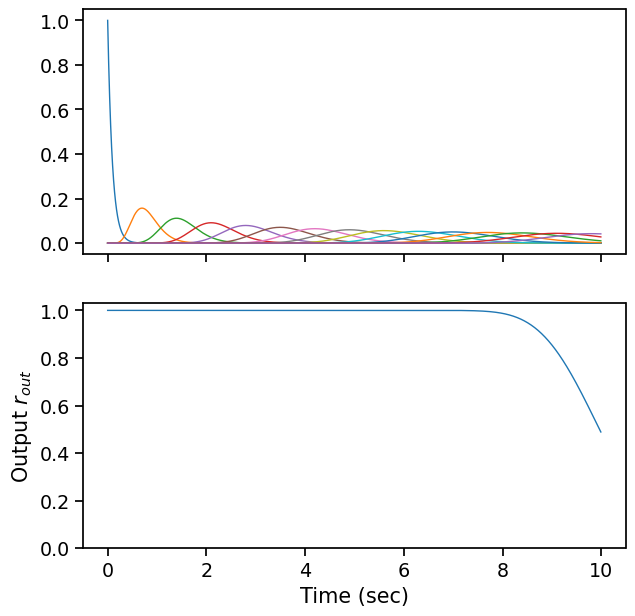

In [7]:
#Figure 1B
#maintained memory of pulse
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
idx = [i for i in range(0, 100, 7)] #select each 7th neuron's activity
axs[0].plot(times, all_r[:,idx])
    
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([0,I*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("Output $r_{out}$");

In [8]:
#Figure 1E: Integration
# step input leads to a linear ramping output with slope proportional to the size of the step
I = .005
x = np.ones(maxT) #step input

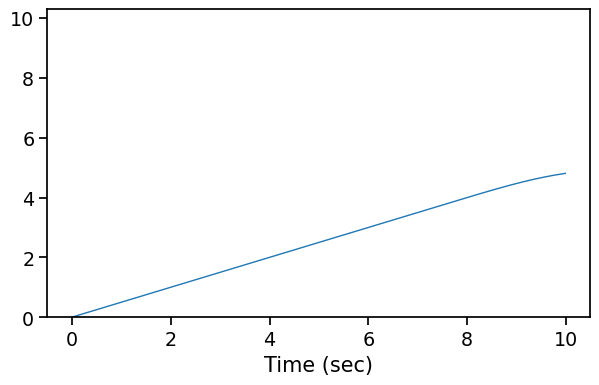

In [9]:
all_r = simulate_network(W, maxT, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharex=True)

ax.plot(times, weighted_sum)
ax.set_ylim([0,10*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");

### Feedforward Processing of Inputs by a Recurrent Network

In [10]:
#Feedforward function of feedforward and recurrent networks
#random orthogonal network 
N=3
random_vecs = np.random.randn(N, N)
U, R = np.linalg.qr(random_vecs)

#feedforward connectivity 
T_matrix = np.diag(np.ones((1, N-1))[0], -1)
W = U @ T_matrix @ np.linalg.inv(U)

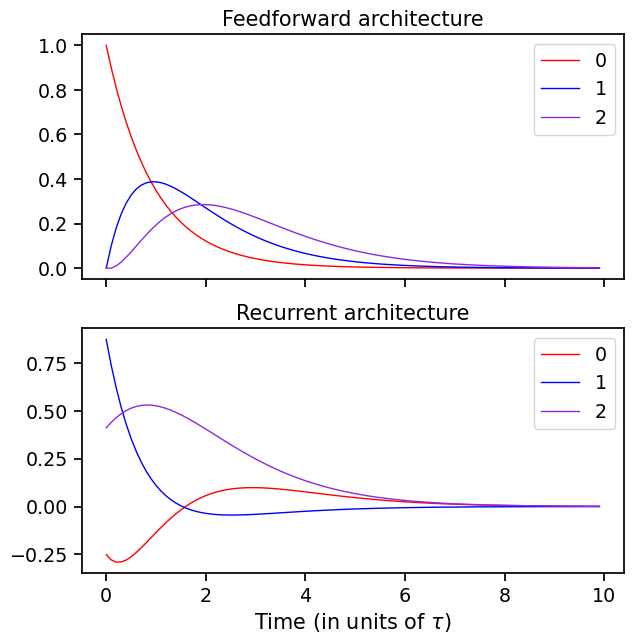

In [11]:
maxT = int(1/dt)
times = np.arange(maxT)*tau
x = np.zeros(maxT)
x[0] = 1
a_weights = np.zeros(N)
a_weights[0] = 1.
all_r_ff = simulate_network(T_matrix, maxT, a_weights, x) 

#for the input to be propagated throught the network equivalently to a neuron's activity, we need to project it onto the correct pattern:
a_weights = U @ a_weights 
all_r_rec = simulate_network(W, maxT, a_weights, x).T

fig, axs = plt.subplots(2,1,  figsize=(7, 7), sharex=True)
colors = ['red', 'blue', 'blueviolet']
for i in range(N):
    axs[0].plot(times, all_r_ff[:,i], c=colors[i], label=i)
    axs[1].plot(times, all_r_rec.T[:,i], c=colors[i], label=i)
axs[0].set_title("Feedforward architecture")
axs[1].set_title("Recurrent architecture")
plt.xlabel(r"Time (in units of $\tau$)");
axs[0].legend();
axs[1].legend();

##### Exercise 3.1: Plot the activity in the rotated neural space (see also Question 32. from the Syllabus)

##### Exercise 3.2 What are the patterns of activity that behave as neurons equivalent to neurons in the feedforward network?

### Schur, but Not Eigenvector, Decomposition Reveals Feedforward Interactions between Patterns of Activity
We will investigate three different networks, a pure feedback network, a functionally feedforward and a functionally mixed.

In [12]:
N = 2
W_pure = np.ones((N,N))/2. #pure feedback

W_fff = np.array([[1,-1],[1,-1]])/2. #functionally feedforward

W_mixed = np.array([[1/2.,-0.3],[1/2.,-0.3]])

weight_list = [W_pure, W_fff, W_mixed]
label_list = ["Pure\nfeedback", "Functionally\nfeedforward", "Functionally mixed"]

a_weights = np.zeros(N)
a_weights[0] = 1.

output_weights =  np.ones(N)

maxT = int(.5/dt)
times = np.arange(maxT)*tau
I = 2
x = np.zeros(maxT)
x[0] = 1

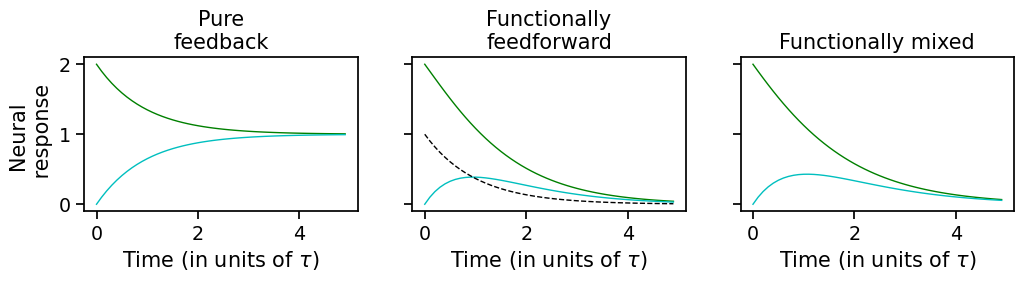

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 2), sharey=True)
for i, W in enumerate(weight_list):
    all_r = simulate_network(W, maxT, a_weights, I*x)
    
    axs[i].plot(times, all_r[:,0], '-g', times, np.abs(all_r[:,1]), '-c')
    axs[i].set_xlabel(r"Time (in units of $\tau$)")
    axs[i].set_title(label_list[i])
exp_dec = np.exp(-times)
axs[1].plot(times, exp_dec, '--k')
axs[0].set_ylabel("Neural \n response");

##### Exercise 4: Read off the eigenvalues of the connectivity matrix from the activity plots for the pure feedback network

##### Exercise 5: Given the eigenvectors, simulate the activity in the eigenmodes

In [14]:
# eigenvectors:
V_pure = np.array([[1,1],[1,-1]])


##### Exercise 6: Given the eigenvectors for the feedforward network, what are the eigenvalues?
- Why can the matrix not be eigendecomposed?

In [15]:
V_feedforward = np.array([[1,1],[1,1]])


C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


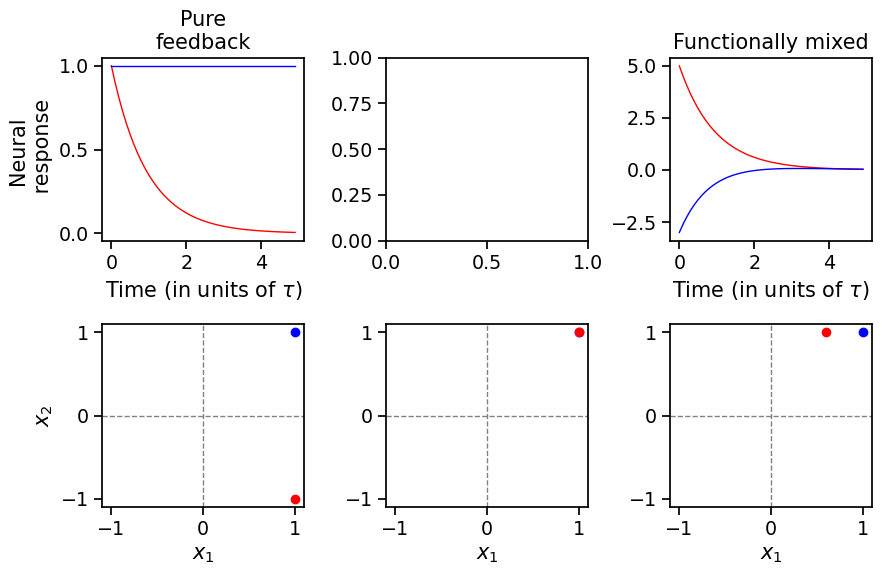

In [16]:
#degenerate eigenvectors: inverse V does not exist
#nonorthogonal eigenvectors: eigenmodes are very different from the Cartesian axes x_1 and x_2 that define the firing activity of the individual neurons
colormap = np.array(['blue', 'red'])

fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i, W in enumerate(weight_list):
    eigvals, eigvecs = np.linalg.eig(W)
    eigvecs /= np.max(eigvecs, axis=0)

    if np.all(np.real(eigvecs[:,0]) != np.real(eigvecs[:,1])):
        all_r = np.linalg.inv(eigvecs.T) @ simulate_network(W, maxT, a_weights, I*x).T 

        axs[0][i].plot(times, all_r[0,:], '-r', times, all_r[1,:], '-b')
        axs[0][i].set_xlabel(r"Time (in units of $\tau$)")
        axs[0][i].set_title(label_list[i])
    else:
        0
        
    for j, (eigval, eigvec) in enumerate(zip(eigvals, eigvecs.T)):
        eignorm = np.linalg.norm(eigval)
        im = axs[1][i].scatter(np.sign(eigvec[0])*eigvec[0], np.sign(eigvec[0])*eigvec[1], c=colormap[j])  #np.where(np.around(eignorm, 10)>0,0,1)
        
    axs[1][i].axhline(0, linestyle='--', color='grey')
    axs[1][i].axvline(0, linestyle='--', color='grey')
    axs[1][i].set_xlim([-1.1,1.1])
    axs[1][i].set_ylim([-1.1,1.1])
    axs[1][i].set_xlabel(r"$x_1$")
    
axs[1][0].set_ylabel(r"$x_2$")
all_r = simulate_network(W, maxT, a_weights, x)
plt.tight_layout();
axs[0][0].set_ylabel("Neural \n response");

In [17]:
##### Exercise 7: How can you see in these plots that the eigenvector represents feedback only onto themselves?

### The Schur Decompositions
The Schur decomposition always produces orthogonal eigenmodes.

This means that the Schur, but not the eigenvector, modes behave analogously to interconnected neurons

The Schur decomposition can be computed with scipy's linalg.schur:

T, U = scipy.linalg.schur(W)

Which gives us the decomposition $$W = U T U^{-1}$$

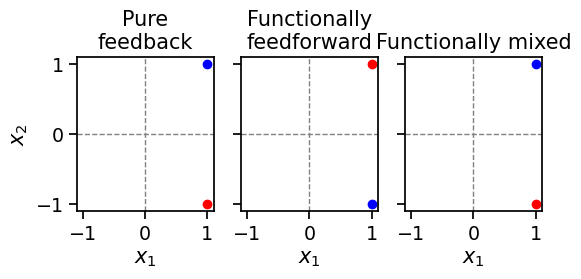

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharey=True)
for i, W in enumerate(weight_list):
    T_mat, U = scipy.linalg.schur(W)
    U /=  np.max(U, axis=1) # np.linalg.norm(U, axis=1)
    U *= np.sign(U[1,:])
    for j, (eigval, eigvec) in enumerate(zip(eigvals, U.T)):
        eignorm = np.linalg.norm(eigval)
        im = axs[i].scatter(eigvec[1], eigvec[0], c=colormap[j])  #np.where(np.around(eignorm, 10)>0,0,1)
        
    axs[i].axhline(0, linestyle='--', color='grey')
    axs[i].axvline(0, linestyle='--', color='grey')
    axs[i].set_xlim([-1.1,1.1])
    axs[i].set_ylim([-1.1,1.1])

    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_title(label_list[i])
    
axs[0].set_ylabel(r"$x_2$");

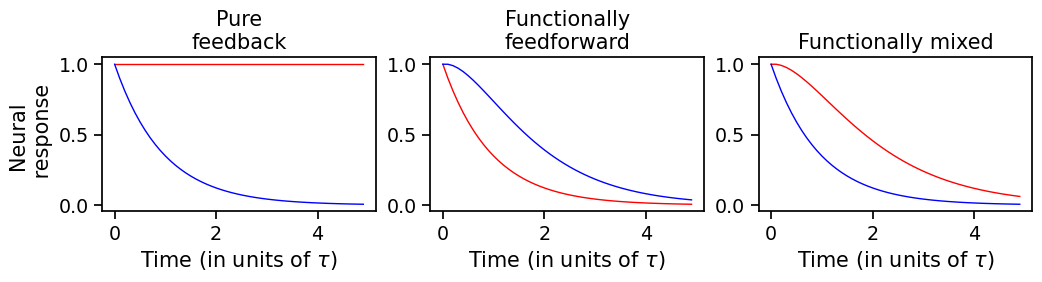

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
for i, W in enumerate(weight_list):
    T_mat, U = scipy.linalg.schur(W)
    U /= np.sqrt(2)
    U *= np.sign(U[0,:])
    all_r =  U.T @ simulate_network(W, maxT, a_weights, I*x).T
    
    axs[i].plot(times, all_r[0,:], '-r', times, all_r[1,:], '-b')
    axs[i].set_xlabel(r"Time (in units of $\tau$)")
    axs[i].set_title(label_list[i])
axs[0].set_ylabel("Neural \n response");

##### Exercise 8: How can you reconstruct the neural activity from the activities of the Schur modes?
Hint: _Balanced Amplification: A New Mechanism of Selective Amplification of Neural Activity Patterns_
Murphy, Brendan K., and Kenneth D. Miller. "Balanced amplification: a new mechanism of selective amplification of neural activity patterns." Neuron 61.4 (2009): 635-648.


#### Some additional networks

In [20]:
# transient amplification
W_mixed = np.array([[1+1/2.,-1.8],[1+1/2.,-1.8]]) 

In [21]:
#cyclic network
N = 10
maxT = int(10/dt)
times = np.arange(maxT)*dt

W = np.diag(np.ones((1, N-1))[0], -1) #(feedfoward + one connection last to first unit)
W[0,-1] = 1.

a_weights = np.zeros(N)
a_weights[0] = 1.

I = 1
x = np.zeros(maxT)
x[0] = 1
all_r = simulate_network(W, maxT, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

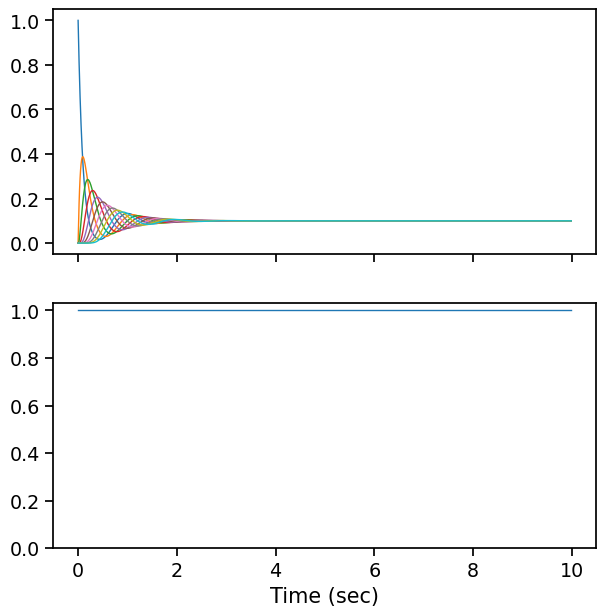

In [22]:
#Figure 
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
axs[0].plot(times, all_r)
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([0,I*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");

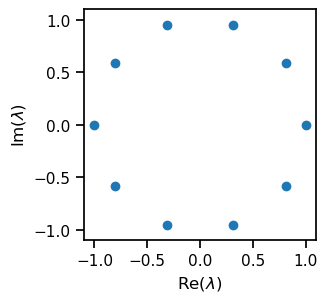

In [23]:
sns.set_context("notebook", font_scale=1.)
eigvals, eigvecs = np.linalg.eig(W)
plot_eigenvalues(eigvals);

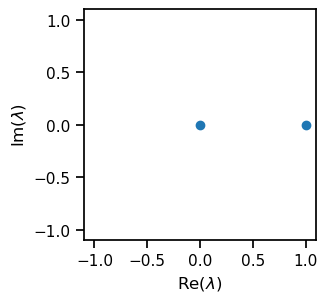

In [24]:
#line attractor (low-rank network)
N = 2
a = np.random.randn(N)
b = np.random.randn(N)
a, b = (a,b)/np.sqrt(np.inner(a,b))
W = np.outer(a, b)

eigvals, eigvecs = np.linalg.eig(W)
plot_eigenvalues(eigvals)

In [25]:
x = np.zeros(maxT)
x[0] = 1
a_weights = np.zeros(N)
a_weights[0] = 1.

all_r = simulate_network(W, maxT, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

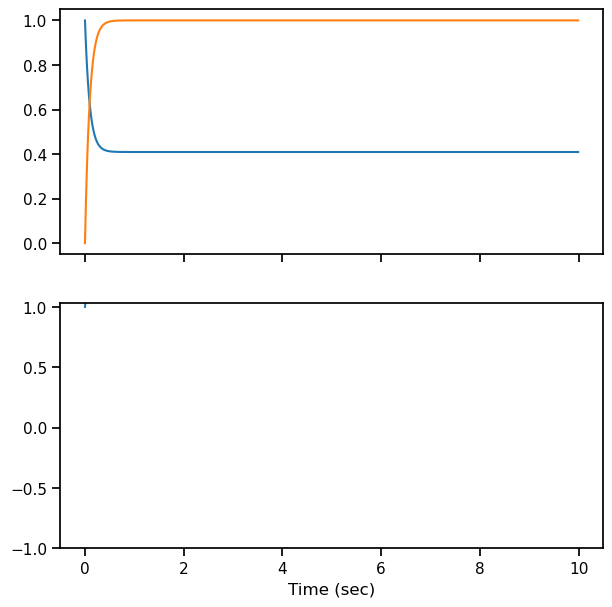

In [26]:
#Figure 
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
axs[0].plot(times, all_r)
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([-1,1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");